In [ ]:
import numpy as np
import scipy.io

scipy.io.loadmat('Ag3/rates.mat')

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACA64, Created on: Mon Jan  1 13:41:32 2024',
 '__version__': '1.0',
 '__globals__': [],
 'Ke': array([[0.51305627, 0.40734293, 0.17793968, 0.26288726, 0.23945907,
         0.20132286, 0.18627218, 0.18208064, 0.16782497, 0.15222925,
         0.14293715, 0.14976333, 0.14779419, 0.10054667, 0.09165488,
         0.08924456, 0.09070592, 0.08868809, 0.08869469, 0.08796668,
         0.08888803, 0.08898142, 0.0883102 , 0.08852341]]),
 'Kh': array([[1.43668582, 0.21803212, 0.19490518, 0.20708593, 0.18258182,
         0.13941256, 0.14105769, 0.13773302, 0.13356459, 0.13107936,
         0.12759837, 0.12287635, 0.09695967, 0.09699222, 0.09577202,
         0.09389894, 0.09366064, 0.09200363, 0.09575605, 0.09562147,
         0.094173  , 0.09354044, 0.09325327, 0.09058369]]),
 'iE': array([[ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25]], dtype=uint8),
 'iH': array([[ 2,  3,  4,  5,  6,  7,  8,

In [ ]:
# Prepare the input files RRR and rates
# Original RRR is 62x62, from HO-30 to LU+30
def collect_data(filename_RRR, filename_rates):
    RRR = np.loadtxt(filename_RRR)
    data = scipy.io.loadmat(filename_rates)
    HO=30
    LU=HO+1
    iH_start = 2
    iH_end = 25
    iE_start = 2
    iE_end = 25
    # treat e and h separately
    RRRh = RRR[HO-iH_end+1:LU,HO-iH_end+1:LU] #include HO=30
    RRRe = RRR[LU:LU+iE_end,LU:LU+iE_end] #include LU=31


    # number_of_features: C(25,2)=25x24/2
    # e.g. for h, 25 is HO-24. orbitals from HO-24 to HO all contribute.
    n_features = 12*25
    # 24 initial conditions for h
    # 24 initial conditions for e
    X = np.zeros((RRRh.shape[0]+RRRe.shape[0]-2, n_features))
    #
    for i in range(RRRh.shape[0]-1):
      X[i, :] = RRRh[np.triu_indices(RRRh.shape[0], k=1)]
      RRRh[:, -1-i] = 0

    for i in range(RRRe.shape[0]-1):
      X[i+RRRh.shape[0]-1, :] = RRRe[np.triu_indices(RRRe.shape[0], k=1)]
      RRRe[:, -1-i] = 0

    ke = data['Ke'].flatten()[::-1]
    kh = data['Kh'].flatten()[::-1]
    y = np.hstack((kh, ke))
    return X, y

In [ ]:
# suppose our initial conditions are ho-4, ho-3, ho-2, ho-1
# we have converted RRR into RRRh, which is 5x5, i.e. ho-4 to ho
# for initial condition ho-4, we care about 10 pairs:
# (ho-4,ho-3), (ho-4,ho-3), (ho-4,ho-2), (ho-4,ho-1), (ho-4,ho),
# (ho-3,ho-2), (ho-3,ho-1), (ho-3,ho),
# (ho-2,ho-1), (ho-2,ho)
# (ho-1,ho)
# for initial condition ho-3, we care about 6 pairs:
# 0, 0, 0, 0
# (ho-3,ho-2), (ho-3,ho-1), (ho-3,ho),
# (ho-2,ho-1), (ho-2,ho)
# (ho-1,ho)
# for initial condition ho-2, we care about 3 pairs:
# 0, 0, 0, 0
# 0, 0, 0,
# (ho-2,ho-1), (ho-2,ho)
# (ho-1,ho)
# for initial condition ho-1, we care about 1 pairs:
# 0, 0, 0, 0
# 0, 0, 0,
# 0, 0,
# (ho-1,ho)
RRRh = np.arange(25).reshape(5, -1)
RRRh = (RRRh + RRRh.T) / 6
np.fill_diagonal(RRRh, 0)
print(RRRh)
X = np.zeros((4,10))
for i in range(4):
      X[i, :] = RRRh[np.triu_indices(RRRh.shape[0], k=1)]
      RRRh[:, -1-i] = 0
print()
print(X)


[[0. 1. 2. 3. 4.]
 [1. 0. 3. 4. 5.]
 [2. 3. 0. 5. 6.]
 [3. 4. 5. 0. 7.]
 [4. 5. 6. 7. 0.]]

[[1. 2. 3. 4. 3. 4. 5. 5. 6. 7.]
 [1. 2. 3. 0. 3. 4. 0. 5. 0. 0.]
 [1. 2. 0. 0. 3. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
filename = ['Si', 'Ag3', 'Ag4', 'Ag5', 'Ag6', 'Ag7']
X_all = []
y_all = []

for i in range(len(filename)):
    X, y = collect_data(filename[i]+'/RRR', filename[i]+'/rates.mat')
    one_hot = np.zeros(len(filename))
    one_hot[i] = 1
    one_hot = np.tile(one_hot, (X.shape[0],1))
    X = np.hstack((X, one_hot))
    X_all.append(X)
    y_all.append(y)

X = np.vstack(X_all)
y = np.hstack(y_all)

n_select_features = X.shape[1] - len(filename)
# convert fs-1 to ps-1
X[:, :n_select_features] = X[:, :n_select_features] * 1.0e3

In [ ]:
from sklearn.model_selection import train_test_split
import torch

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   train_size=0.8,
                                                   random_state=123)
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

class TrainDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_ds = TrainDataset(X_train, y_train)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size=batch_size,
                     shuffle=True)

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        l1 = nn.Linear(input_size, hidden_size[0])
        a1 = nn.ReLU()
        l2 = nn.Linear(hidden_size[0], hidden_size[1])
        a2 = nn.ReLU()
        l3 = nn.Linear(hidden_size[1], hidden_size[2])
        a3 = nn.ReLU()
        l4 = nn.Linear(hidden_size[2], hidden_size[3])
        a4 = nn.ReLU()
        l5 = nn.Linear(hidden_size[3], output_size)
        l = [l1, a1, l2, a2, l3, a3, l4, a4, l5]
        self.layers = nn.ModuleList(l)

    def forward(self, x):
        for f in self.layers:
            x = f(x)
        return x

import copy
input_size = X_train.shape[1]
hidden_size = [512, 256, 64, 16]
output_size = 1
num_epochs = 100
lr = 0.0001
model = Model(input_size, hidden_size, output_size)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
loss_hist_train = [0] * num_epochs
loss_hist_test = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:,0]
        loss = loss_fn(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_hist_train[epoch] += loss.item()
    loss_hist_train[epoch] /= len(train_ds)/batch_size
    pred = model(X_test)[:,0]
    loss = loss_fn(pred, y_test)
    loss_hist_test[epoch] += loss.item()

    if loss.item() < best_mse:
        best_mse = loss.item()
        best_weights = copy.deepcopy(model.state_dict())

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1} ')
        print(f'training loss: {loss_hist_train[epoch]:.4f} ')
        print(f'testing loss: {loss_hist_test[epoch]:.4f} ')
        print('-'*50)

epoch: 10 
training loss: 0.2344 
testing loss: 0.1016 
--------------------------------------------------
epoch: 20 
training loss: 0.2112 
testing loss: 0.0787 
--------------------------------------------------
epoch: 30 
training loss: 0.1992 
testing loss: 0.0752 
--------------------------------------------------
epoch: 40 
training loss: 0.1950 
testing loss: 0.0707 
--------------------------------------------------
epoch: 50 
training loss: 0.1807 
testing loss: 0.0697 
--------------------------------------------------
epoch: 60 
training loss: 0.1782 
testing loss: 0.0684 
--------------------------------------------------
epoch: 70 
training loss: 0.1706 
testing loss: 0.0677 
--------------------------------------------------
epoch: 80 
training loss: 0.1684 
testing loss: 0.0622 
--------------------------------------------------
epoch: 90 
training loss: 0.1630 
testing loss: 0.0615 
--------------------------------------------------
epoch: 100 
training loss: 0.1589 
te

In [ ]:
# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    pred = model(X_test)[:,0]
    pred_train = model(X_train)[:,0]
    loss = loss_fn(pred, y_test)
    mae_loss = nn.L1Loss()(pred, y_test)
    print(f'test MSE loss: {loss.item()}')
    print(f'test MAE loss: {mae_loss.item()}')


test MSE loss: 0.05932234600186348
test MAE loss: 0.07852663844823837


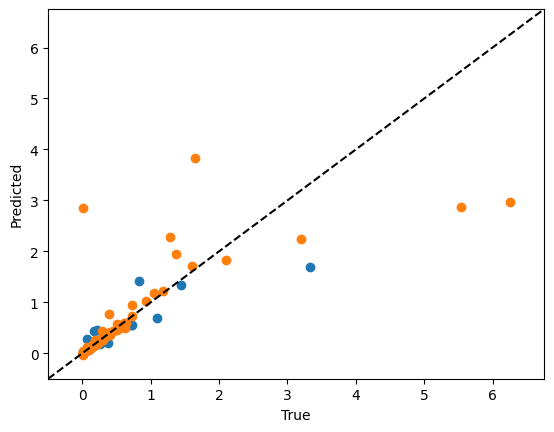

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, pred)
plt.scatter(y_train, pred_train)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.xlim(-0.5, y.max()+0.5)
plt.ylim(-0.5, y.max()+0.5)
plt.plot([-0.5, y.max()+0.5], [-0.5, y.max()+0.5], 'k--')
plt.show()